## Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from scipy.stats import pearsonr
dataroot = '/content/drive/MyDrive/AIST_Project/traffic/traffic_df.csv'
#dataroot = "/content/drive/MyDrive/AIST_Project/traffic/nasdaq100_padding.csv"

In [3]:
from pathlib import Path
import os
import sys

dirname = Path(os.path.abspath('/content/drive/MyDrive/AIST_Project/traffic/'))
root = dirname.parent

sys.path.insert(0, str(root))

import torch

torch.__version__

'1.10.0+cu111'

## Parameters

In [4]:
NORMALIZE_DATA = True
WINDOW_SIZE = 48
Y_DIM = 1
ENCODER_HIDDEN_STATES = 128
DECODER_HIDDEN_STATES = 128
BATCH_SIZE = 256

VALIDATION_RATIO = 0.1
DROPOUT = 0

In [5]:
!pip install poutyne
!pip install torchmetrics
!pip install get-rolling-window
!pip install da-rnn[torch]

     |████████████████████████████████| 210 kB 5.3 MB/s 
     |████████████████████████████████| 408 kB 43.2 MB/s 
     |████████████████████████████████| 14.8 MB 5.1 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


## Data preprocessing

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import sklearn

def lagger(df, n_shifts):
  #df2 = pd.DataFrame(df, columns = ['Price'])
  for col in ["traffic_volume"]:
      for shift_amount in range(1, n_shifts+1):
          df[f"{col}.lag{shift_amount}"] = df[col].shift(shift_amount)
  df = df.dropna()
  return df

traffic_df =  pd.read_csv(dataroot)

hol_col = (pd.get_dummies(traffic_df['holiday']).columns).values.tolist()
weather_col = (pd.get_dummies(traffic_df['weather_main']).columns).values.tolist()

cols = ["temp",	"rain_1h",	"snow_1h",	"clouds_all", "hour",	"dayofweek",	"quarter",	"month",	"year",	"dayofyear",	"dayofmonth",	"weekofyear", 'traffic_volume.lag1', 'traffic_volume.lag2', 'traffic_volume.lag3', 'traffic_volume.lag4', 'traffic_volume.lag5', 'traffic_volume.lag6', 'traffic_volume.lag7', 'traffic_volume.lag8', 'traffic_volume.lag9', 'traffic_volume.lag10']
cols.extend(hol_col)
cols.extend(weather_col)
cols.extend(["traffic_volume"])
traffic_df = lagger(traffic_df, 10)
traffic_df = traffic_df.dropna()
X = traffic_df[cols]
#y = traffic_df["traffic_volume"]
#X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=1000, random_state=42, shuffle = False)
raw_data =  X
df1 = raw_data.pop('traffic_volume') # remove column x and store it in df2
raw_data['traffic_volume']=df1 # add b series as a 'new' column.

scale = StandardScaler().fit(raw_data)

if NORMALIZE_DATA:
    data = scale.transform(raw_data)
else:
    data = raw_data
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
from get_rolling_window import rolling_window

def get_labels_from_features(features, window_size, y_dim):
    return features[window_size - 1:, -y_dim:]


def split_by_ratio(features, validation_ratio):
    length = len(features)
    validation_length = int(validation_ratio * length)

    return features[:-validation_length], features[-validation_length:]


def split_data(
    data,
    apply,
    window_size,
    y_dim,
    validation_ratio
):
    train_data, val_data = split_by_ratio(data, validation_ratio)

    train_f, train_l = rolling_window(
        train_data, window_size, 1
    ), get_labels_from_features(train_data, window_size, y_dim)

    val_f, val_l = rolling_window(
        val_data, window_size, 1
    ), get_labels_from_features(val_data, window_size, y_dim)

    return apply(train_f), apply(train_l), apply(val_f), apply(val_l)



In [8]:
from torch.utils.data import TensorDataset, DataLoader


def to_tensor(array):
    return torch.from_numpy(array).float()
    
data1 = data[:-9632]
data2 = data[-9632:]

train_X, train_y, val_X, val_y = split_data(data1, to_tensor, WINDOW_SIZE, Y_DIM, VALIDATION_RATIO)

print('train_X, train_y :', train_X.shape, train_y.shape)
print('  val_X,   val_y :', val_X.shape, val_y.shape)

train_X, train_y : torch.Size([34650, 48, 46]) torch.Size([34650, 1])
  val_X,   val_y : torch.Size([3808, 48, 46]) torch.Size([3808, 1])


## Training loop

In [9]:
from da_rnn.torch import DARNN, DEVICE
from poutyne import Model, EarlyStopping, ModelCheckpoint

EPOCHS = 100

darnn = DARNN(
    n=train_X.shape[2] - 1,
    T=WINDOW_SIZE,
    m=ENCODER_HIDDEN_STATES,
    p=DECODER_HIDDEN_STATES,
    y_dim=Y_DIM,
    dropout=DROPOUT
)

model = Model(
    darnn,
    'adam',
    'mse',
    device=DEVICE
)

save_to = dirname / 'checkpoint_torch.hdf5'

history = model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5),
        ModelCheckpoint(
            str(save_to.absolute()),
            monitor='val_loss',
            verbose=1,
            save_best_only=True,
            keep_only_last_best=True
        )
    ]
)

Epoch:   1/100 Train steps: 136 Val steps: 15 1m6.61s loss: 0.502519 val_loss: 0.131385
Epoch 1: val_loss improved from inf to 0.13139, saving file to /content/drive/MyDrive/AIST_Project/traffic/checkpoint_torch.hdf5
Epoch:   2/100 Train steps: 136 Val steps: 15 1m6.13s loss: 0.132105 val_loss: 0.078710
Epoch 2: val_loss improved from 0.13139 to 0.07871, saving file to /content/drive/MyDrive/AIST_Project/traffic/checkpoint_torch.hdf5
Epoch:   3/100 Train steps: 136 Val steps: 15 1m5.36s loss: 0.111384 val_loss: 0.077711
Epoch 3: val_loss improved from 0.07871 to 0.07771, saving file to /content/drive/MyDrive/AIST_Project/traffic/checkpoint_torch.hdf5
Epoch:   4/100 Train steps: 136 Val steps: 15 1m5.39s loss: 0.103035 val_loss: 0.066510
Epoch 4: val_loss improved from 0.07771 to 0.06651, saving file to /content/drive/MyDrive/AIST_Project/traffic/checkpoint_torch.hdf5
Epoch:   5/100 Train steps: 136 Val steps: 15 1m5.29s loss: 0.098420 val_loss: 0.066137
Epoch 5: val_loss improved from 

## Performance

In [12]:
from sklearn.metrics import mean_squared_error
VALIDATION_RATIO = 0.005
train_X, train_y, val_X, val_y = split_data(data2, to_tensor, WINDOW_SIZE, Y_DIM, VALIDATION_RATIO)

def predict(model, X):
    with torch.no_grad():
        return model(X)
train_X = torch.cat((train_X, val_X), 0)
train_y = torch.cat((train_y, val_y), 0)

train_y_hat = predict(darnn, train_X.to(DEVICE))


In [15]:
#y_hat = (scale.inverse_transform(train_y_hat.cpu().repeat(1,46).numpy()))[:,-1]
#y = (scale.inverse_transform(train_y.cpu().repeat(1,46).numpy()))[:,-1]
from scipy.stats import pearsonr

y_hat = ((train_y_hat.cpu().repeat(1,46).numpy()))[:,-1]
y = ((train_y.cpu().repeat(1,46).numpy()))[:,-1]
print(mean_squared_error(y, y_hat, squared=False))
print(mean_absolute_error(y, y_hat))
print(pearsonr(y, y_hat))

0.19626883
0.13722344
(0.9803509673048962, 0.0)


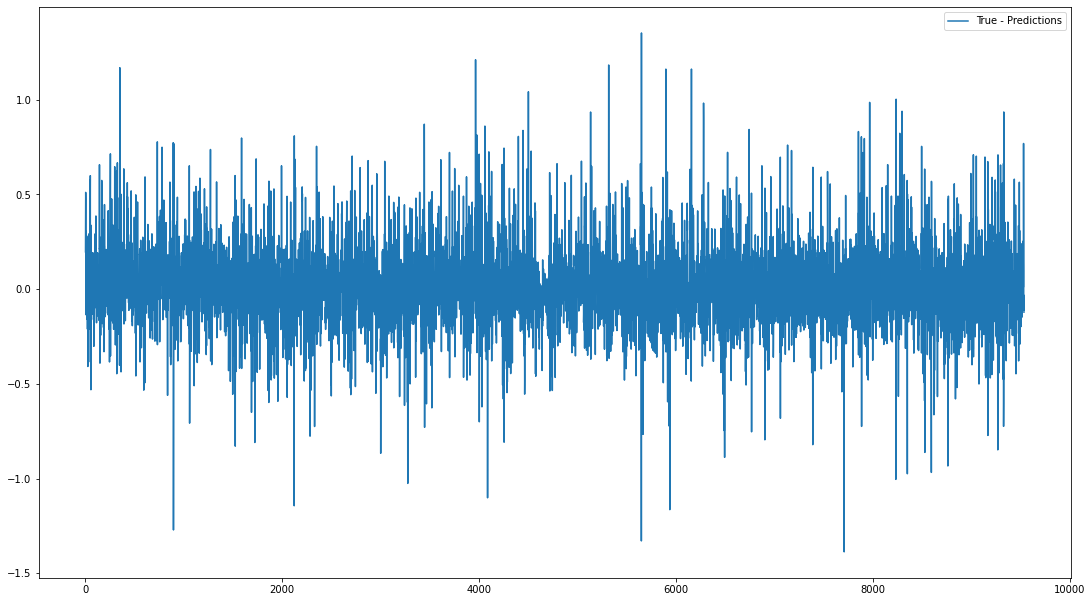

In [14]:
x = np.arange(0,len(y_hat)) 
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(x, y - y_hat, label = "True - Predictions")
#plt.plot(x,y_test,  label = "True")
plt.legend()
plt.show()

In [ ]:
len(val_X)